In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [2]:
from config import ALPACA_CONFIG

api_key = ALPACA_CONFIG["API_KEY"]
api_secret = ALPACA_CONFIG["API_SECRET"]
base_url = ALPACA_CONFIG["ENDPOINT"]

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import DataFeed
client = StockHistoricalDataClient(api_key, api_secret)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Date Range: last 5 years
end_dt = datetime.now(timezone.utc)
start_dt = end_dt - relativedelta(years=5)

# Daily SPY Bars
req = StockBarsRequest(
    symbol_or_symbols="SPY",
    timeframe=TimeFrame.Day,
    start=start_dt,
    end=end_dt,
    limit=10000,          # plenty for 5y daily
    adjustment="split",   # adjust for splits (common choice)
    feed=DataFeed.IEX,
)
bars_resp = client.get_stock_bars(req)

df = bars_resp.df.copy()

if isinstance(df.index, pd.MultiIndex):
    df = df.xs("SPY", level=0)

df = df.sort_index()
use_cols = [c for c in ["open", "high", "low", "close", "volume", "vwap"] if c in df.columns]
df = df[use_cols].copy()

rolling_window = 20

df["SMA"] = df["close"].rolling(rolling_window).mean()
df["STD"] = df["close"].rolling(rolling_window).std()
df["Upper_BB"] = df["SMA"] + 2 * df["STD"]
df["Lower_BB"] = df["SMA"] - 2 * df["STD"]

# Daily log returns & cumulative return index
df["log_return"] = np.log(df["close"]).diff()
df["cum_return_idx"] = (df["log_return"].cumsum()).apply(np.exp)

# Realized volatility (annualized) using rolling std of daily returns
df["ret"] = df["close"].pct_change()
df["ann_vol_20d"] = df["ret"].rolling(rolling_window).std() * np.sqrt(252)

print("Rows:", len(df))
print(df.tail())

Rows: 1254
                              open    high      low    close     volume  \
timestamp                                                                 
2025-09-29 04:00:00+00:00  664.375  665.17  661.890  663.650  1550736.0   
2025-09-30 04:00:00+00:00  662.910  666.65  661.625  666.060  1435659.0   
2025-10-01 04:00:00+00:00  663.195  669.37  663.090  668.535  1375663.0   
2025-10-02 04:00:00+00:00  670.455  670.55  666.815  669.150  1276773.0   
2025-10-03 04:00:00+00:00  670.005  672.66  668.170  669.210  1396816.0   

                                 vwap        SMA       STD    Upper_BB  \
timestamp                                                                
2025-09-29 04:00:00+00:00  663.494592  656.34525  7.468787  671.282824   
2025-09-30 04:00:00+00:00  664.066352  657.62825  6.755413  671.139075   
2025-10-01 04:00:00+00:00  667.204198  658.87475  6.317506  671.509763   
2025-10-02 04:00:00+00:00  668.857387  659.88125  6.268176  672.417603   
2025-10-03 04:00:00

In [4]:
#Compute SMAs
df["SMA_20"]  = df["close"].rolling(20).mean()
df["SMA_50"]  = df["close"].rolling(50).mean()
df["SMA_200"] = df["close"].rolling(200).mean()

# RSI (14-day)
window = 14
delta = df["close"].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# Volume colors (green if close >= previous close)
up = df["close"] >= df["close"].shift(1)
vol_colors = np.where(up, "green", "red")

# Figure with 3 subplots: price, volume, RSI
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    row_heights=[0.55, 0.25, 0.20],
    subplot_titles=("Candlestick with SMAs", "Volume", "RSI (14)")
)

# Candlestick + SMAs
fig.add_trace(go.Candlestick(x=df.index, open=df["open"], high=df["high"],
                             low=df["low"], close=df["close"],
                             name="SPY"), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["SMA_20"],  mode="lines", name="SMA 20"),  row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["SMA_50"],  mode="lines", name="SMA 50"),  row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["SMA_200"], mode="lines", name="SMA 200"), row=1, col=1)

# Volume bars
fig.add_trace(go.Bar(x=df.index, y=df["volume"], marker_color=vol_colors,
                     name="Volume", opacity=0.8), row=2, col=1)

# RSI line + 30/70 reference bands
fig.add_trace(go.Scatter(x=df.index, y=df["RSI_14"], mode="lines", name="RSI 14",
                         line=dict(color="orange")), row=3, col=1)
fig.add_hrect(y0=70, y1=70, line_width=1, line_dash="dash", fillcolor="red",
              opacity=0.3, row=3, col=1)
fig.add_hrect(y0=30, y1=30, line_width=1, line_dash="dash", fillcolor="green",
              opacity=0.3, row=3, col=1)

fig.update_layout(
    title="SPY Stock Price, Volume and RSI Analysis",
    xaxis=dict(showgrid=False, rangeslider=dict(visible=False)),
    xaxis2=dict(showgrid=False),
    xaxis3=dict(showgrid=False),
    yaxis_title="Price (USD)",
    yaxis2_title="Volume",
    yaxis3_title="RSI",
    legend=dict(orientation="v", x=1.02, y=1),
    height=900,
    margin=dict(l=50, r=50, t=60, b=40)
)

fig.show()

In [5]:
# Block 3: Features & target
features = [
    "open", "high", "low", "close", "volume",
    "SMA_20", "SMA_50", "SMA_200",
    "Upper_BB", "Lower_BB", "RSI_14", "ann_vol_20d", "log_return", "vwap"
]

# Drop rows with NaNs
data = df[features].dropna().copy()

# Directional target: 1 if tomorrow's close > today's, else 0
data["target"] = (df["close"].shift(-1).reindex(data.index) > data["close"].reindex(data.index)).astype(int)

data = data.dropna()

In [6]:
# Block 4: Split indices (e.g., 70% train, 10% val, 20% test)
n = len(data)
train_end = int(n * 0.7)
val_end   = int(n * 0.8)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

X_train_raw = train_df[features].values
y_train = train_df["target"].values.astype(int)

X_val_raw = val_df[features].values
y_val = val_df["target"].values.astype(int)

X_test_raw = test_df[features].values
y_test = test_df["target"].values.astype(int)

# Scale on train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled   = scaler.transform(X_val_raw)
X_test_scaled  = scaler.transform(X_test_raw)

In [7]:
# Block 5: Utility to make rolling windows of sequences
def make_sequences(X_scaled, y, window_size=20):
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window_size):
        X_seq.append(X_scaled[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 20

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train, window_size)
X_val_seq,   y_val_seq   = make_sequences(X_val_scaled,   y_val,   window_size)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test,  window_size)

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape

((718, 20, 14), (86, 20, 14), (191, 20, 14))

In [8]:
# Block 6: Model
model = Sequential([
    LSTM(64, input_shape=(window_size, len(features))),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Block 7: Train with validation
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5042 - loss: 0.7011 - val_accuracy: 0.6163 - val_loss: 0.6724
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5195 - loss: 0.6960 - val_accuracy: 0.6163 - val_loss: 0.6756
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5460 - loss: 0.6886 - val_accuracy: 0.6163 - val_loss: 0.6803
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5209 - loss: 0.6925 - val_accuracy: 0.6163 - val_loss: 0.6789
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5084 - loss: 0.6872 - val_accuracy: 0.6163 - val_loss: 0.6753
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5515 - loss: 0.6839 - val_accuracy: 0.6163 - val_loss: 0.6779
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5850 - loss: 0.6825 - val_accuracy: 0.5930 - val_loss: 0.6793
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5738 - loss: 0.6834 - val_accuracy: 0.6163 - val_loss:

In [10]:
# Evaluation & Prediction

# 1) Train/Test accuracy
train_loss, train_acc = model.evaluate(X_train_seq, y_train_seq, verbose=0)
test_loss,  test_acc  = model.evaluate(X_test_seq,  y_test_seq,  verbose=0)

# 2) Next-day direction from the most recent window
last_window_raw = data[features].values[-window_size:]
last_window_scaled = scaler.transform(last_window_raw)
last_window_seq = np.expand_dims(last_window_scaled, axis=0)

prob_up = float(model.predict(last_window_seq, verbose=0).item())  # P(up)
pred_dir = "UP" if prob_up > 0.5 else "DOWN"

# 3) Console formatting to match your example
print("\nModel Performance Explanation:")
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print("\nPrediction for tomorrow:")
print(f"Probability of price increase: {prob_up*100:.2f}%")
print(f"Predicted direction: {pred_dir}")


Model Performance Explanation:
Train accuracy: 0.6643
Test accuracy: 0.5340

Prediction for tomorrow:
Probability of price increase: 75.07%
Predicted direction: UP


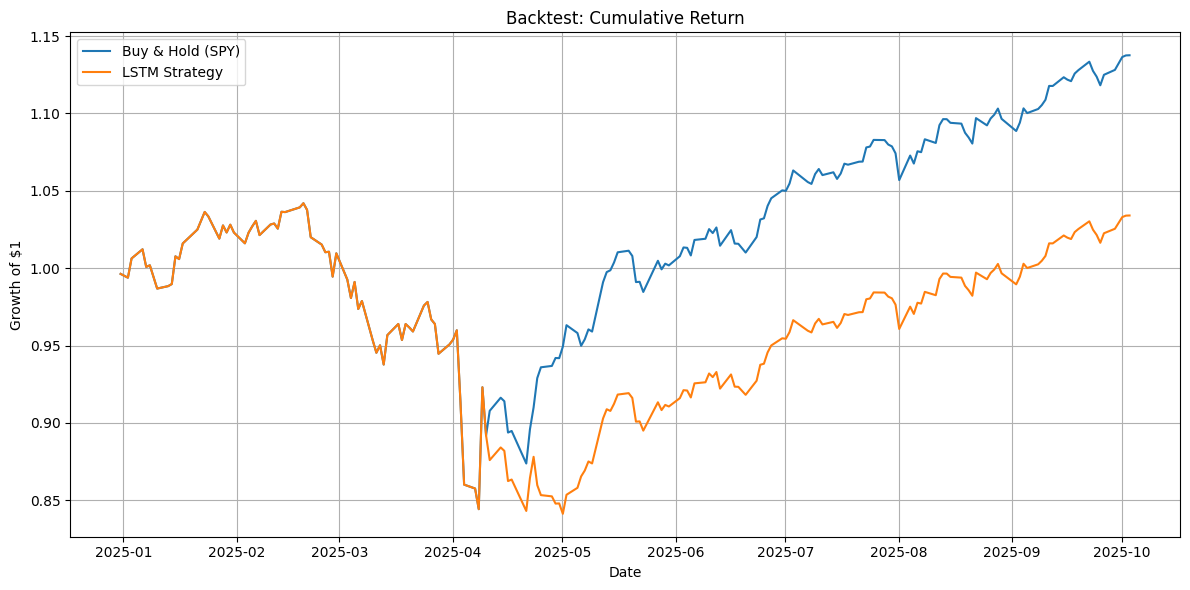


Backtest Results:
Directional Accuracy: 53.68%
Strategy Sharpe Ratio: 0.32


In [12]:
# === BACKTESTING BLOCK ===

# Predict probabilities for test set
y_pred_probs = model.predict(X_test_seq, verbose=0).flatten()

# Convert to signals: 1 if prob > 0.5 else -1
pred_signals = np.where(y_pred_probs > 0.5, 1, -1)

# Align with price data
test_df_trimmed = test_df.iloc[window_size:].copy()
test_df_trimmed["signal"] = pred_signals
test_df_trimmed["return"] = test_df_trimmed["close"].pct_change()

# Strategy returns (shift signal to avoid look-ahead bias)
test_df_trimmed["strategy_return"] = test_df_trimmed["signal"].shift(1) * test_df_trimmed["return"]

# Cumulative returns
test_df_trimmed["cumulative_market"] = (1 + test_df_trimmed["return"]).cumprod()
test_df_trimmed["cumulative_strategy"] = (1 + test_df_trimmed["strategy_return"]).cumprod()

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(test_df_trimmed.index, test_df_trimmed["cumulative_market"], label="Buy & Hold (SPY)")
plt.plot(test_df_trimmed.index, test_df_trimmed["cumulative_strategy"], label="LSTM Strategy")
plt.title("Backtest: Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy of signal direction
from sklearn.metrics import accuracy_score

# True direction: 1 = up, -1 = down
true_returns = test_df_trimmed["return"]
true_dir = np.where(true_returns > 0, 1, -1)

# Shift signal to avoid look-ahead bias
shifted_signal = test_df_trimmed["signal"].shift(1)

# Drop rows where shifted_signal is NaN (first row)
mask = ~shifted_signal.isna()

true_dir_aligned = true_dir[mask]
signal_dir_aligned = shifted_signal[mask]

direction_accuracy = accuracy_score(true_dir_aligned, signal_dir_aligned)

# Sharpe Ratio
sharpe = (test_df_trimmed["strategy_return"].mean() / test_df_trimmed["strategy_return"].std()) * np.sqrt(252)

print(f"\nBacktest Results:")
print(f"Directional Accuracy: {direction_accuracy:.2%}")
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")